# Импорты

Допускается импортировать любые библиотеки

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as sts

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

from sklearn.isotonic import IsotonicRegression

# Задание №1 (код). Борьба с шумом

На одном из предприятий Группы НЛМК - АО СГОК для вывоза горной массы используются карьерные самосвалы БЕЛАЗ_75131, БЕЛАЗ_75306
На карьерных самосвалах установлены крупногабаритные шины (КГШ), расход которых связан с существенными затратами: около 300 шин полностью изнашиваются за 1 год, на закупку новых шин предприятие тратит около 250 млн руб/год -> сокращение темпов износа шин и повышение ходимости (пробег шины в течение жизни) позволяют существенно сократить затраты


Команду цифровизации логистики попросили помочь с одним из проектов по повышению ходимости КГШ с применением продвинутой аналитики: необходимо выявить и оценить влияние основных факторов износа шин. 

Износ шин выражается в скорости истирания (сокращении) глубины протектора шины мм/км: $\frac{ΔC_t}{D_t}$, $ΔC_t$ - разница глубины протектора в конце и начале периода, $D_t$ - пробег шины за период t

В рамках проекта инженеры проводят регулярные измерения глубины протектора шины (новая шина имеет глубину 90 мм, на момент списания глубина протектора - 0 мм) с помощью электронного штангенглубиномера. 

Данные этих измерений являются основой для формирования целевой переменной, но их погрешность +- 3 мм - ниже представлен пример таких данных *df_depths*

**Задача**: напишите код для нивелирования погрешности измерений для последующего использования этих данных в ML модели для факторного анализа износа шин

**Подсказка**: само построение модели может быть очень коротким, но важно правильно проанализировать и подготовить данные, понятно и кратко описать шаги и полученный результат, показать структуру, чистоту и понятность кода

## Exploration analysis 

In [28]:
df = pd.read_excel('data_depths.xlsx')

In [3]:
df.head(10)

,Unnamed: 0,Date_measure,Dist_from_prev_measure,Depth_mm,Car
0,1,2019-01-13,5923.523114,87.255640,101
1,91,2020-10-04,3358.478149,7.828197,101
2,9,2019-03-10,2347.843640,81.070071,101
3,83,2020-08-09,6129.677648,15.775609,101
4,20,2019-05-26,2176.149132,68.516324,101
5,73,2020-05-31,1504.095667,26.264870,101
6,94,2020-10-25,4227.149388,5.815938,101
7,66,2020-04-12,5209.005563,33.394888,101
8,15,2019-04-21,1686.850234,73.063963,101
9,38,2019-09-29,4655.583096,60.433952,101


In [4]:
df.describe()

,Unnamed: 0,Dist_from_prev_measure,Depth_mm,Car
count,79.000000,79.000000,79.000000,79.0
mean,50.607595,3304.545380,44.256205,101.0
std,28.390328,2042.611107,25.399182,0.0
min,0.000000,309.249935,1.695712,101.0
25%,28.000000,1716.564807,22.783581,101.0
50%,52.000000,3091.995231,41.759870,101.0
75%,73.500000,4399.444570,63.934390,101.0
max,99.000000,9834.977120,94.873036,101.0


In [5]:
df['Car'].unique()

array([101], dtype=int64)

##  Препроцессинг

In [29]:
df.sort_values('Date_measure', inplace=True)
df.loc[df.Depth_mm>90, 'Depth_mm'] = 90

In [30]:
df['Total_dist'] = df['Dist_from_prev_measure'].cumsum()

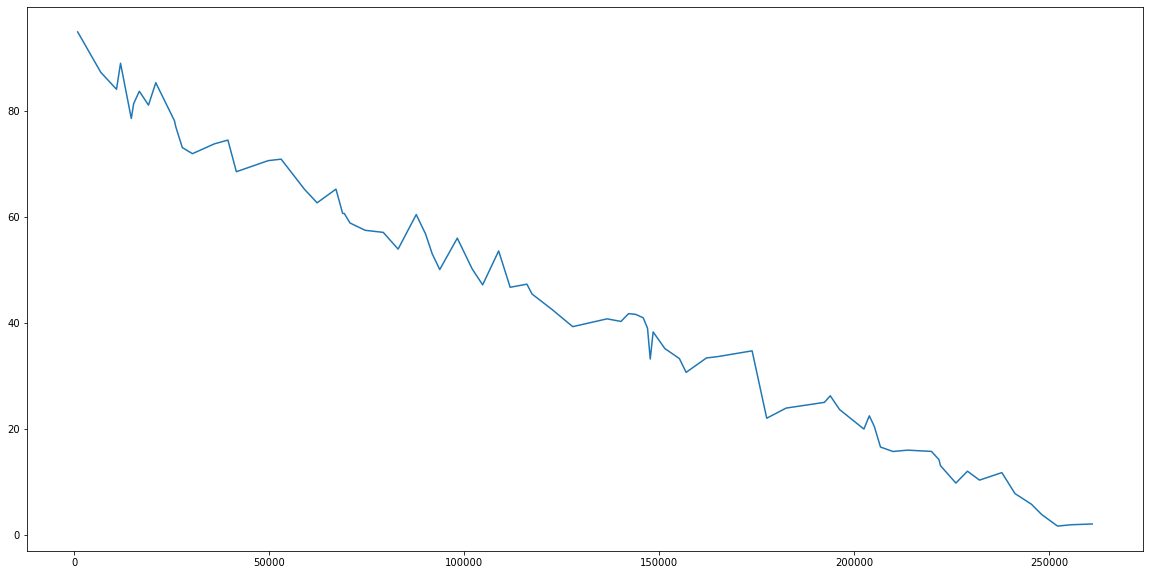

In [8]:
plt.plot(df['Total_dist'], dfs['Depth_mm'])

In [31]:
df['Wear_mm'] =  df['Depth_mm'].shift() - df['Depth_mm'] 
df = df.resample('W', on='Date_measure').mean()
# wrong with dist
df = (df.fillna(method='ffill') + df.fillna(method='bfill'))/2

x = df.Total_dist.values
y = df.Depth_mm.values

In [24]:
def plot_updated_depth(corr_data):
    plt.plot(x, y, '.', color = "b")
    plt.plot(x, corr_data, color = "r")
    plt.xlabel("Total_dist")
    plt.ylabel("Depth_mm")
    mse = ((y-corr_data)**2).mean()
    print(f'MSE: {mse}')

## Модели

MSE: 1.5917190800611476


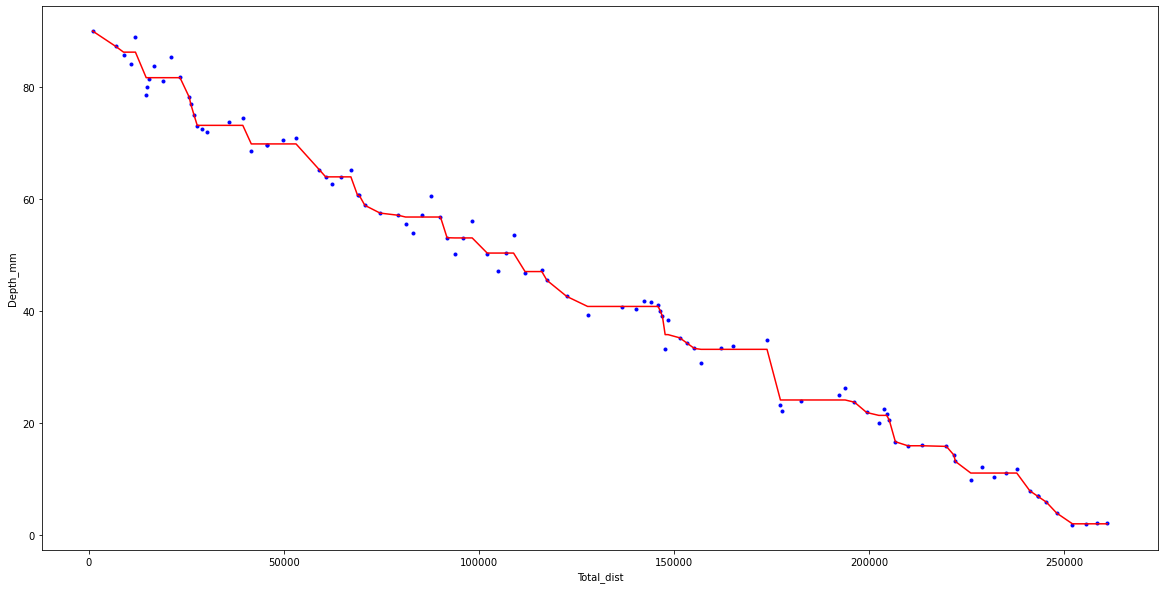

In [33]:
plot_updated_depth(IsotonicRegression(increasing=False).fit_transform(x, y))

MSE: 3.5175766509813093


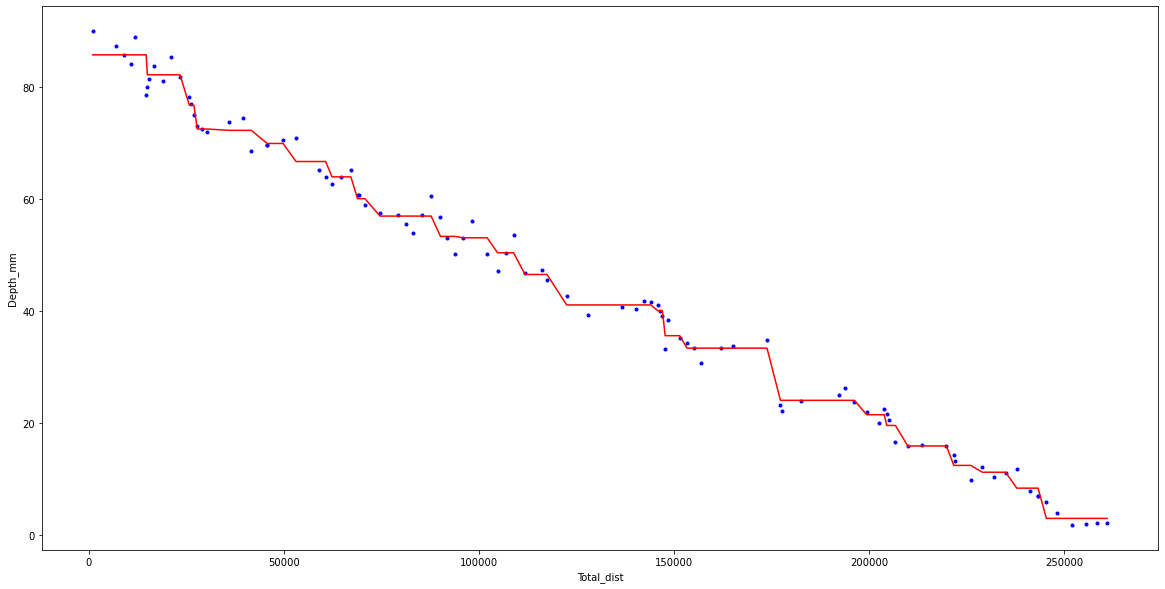

In [34]:
import lightgbm as lgb

monotone_model = lgb.LGBMRegressor(min_child_samples=5, num_leaves=5, monotone_constraints=-1) 
monotone_model.fit(x.reshape(-1, 1), y)
prediction = monotone_model.predict(x.reshape(-1, 1))
plot_updated_depth(prediction)

Изотоническая регрессия значительно меньше отклоняется от исходных данных, визуально чаще попадает точно в точки.

## Упакованное решение

In [35]:
def load_preprocess(filename:str) -> pd.DataFrame:
    
    def resample_with_fill(df):
        df = df.resample('W', on='Date_measure').mean()
        df = (df.fillna(method='ffill') + df.fillna(method='bfill'))/2
        return df
    
    def dist_to_total(df):
        df['Total_dist'] = df['Dist_from_prev_measure'].cumsum()
        df.drop('Dist_from_prev_measure', axis='columns', inplace=True)
        return df
    
    def make_monotone(series):
        x = df.Total_dist.values
        y = series.values
        return IsotonicRegression(increasing=False).fit_transform(x, y)
    
    df = pd.read_excel(filename)
    df.sort_values('Date_measure', inplace=True)
    df.loc[df.Depth_mm>90, 'Depth_mm'] = 90
    df = resample_with_fill(df)
    df = dist_to_total(df)
    df['Depth_mm_corrected'] = make_monotone(df.Depth_mm)
    df.loc[df.Depth_mm_corrected<0, 'Depth_mm'] = 0
    
    return df

df = load_preprocess('data_depths.xlsx')
df

,Unnamed: 0,Depth_mm,Car,Total_dist,Depth_mm_corrected
Date_measure,,,,,
2019-01-06,0.0,90.000000,101.0,908.614306,90.000000
2019-01-13,1.0,87.255640,101.0,6832.137420,87.255640
2019-01-20,2.0,85.654731,101.0,11809.266762,86.222804
2019-01-27,3.0,84.053821,101.0,15840.002332,86.222804
2019-02-03,4.0,88.959859,101.0,16874.737869,86.222804
...,...,...,...,...,...
2020-11-01,95.0,3.868384,101.0,317819.633535,3.868384
2020-11-08,96.0,1.695712,101.0,321876.591376,1.940079
2020-11-15,97.0,1.948972,101.0,325387.437987,1.940079


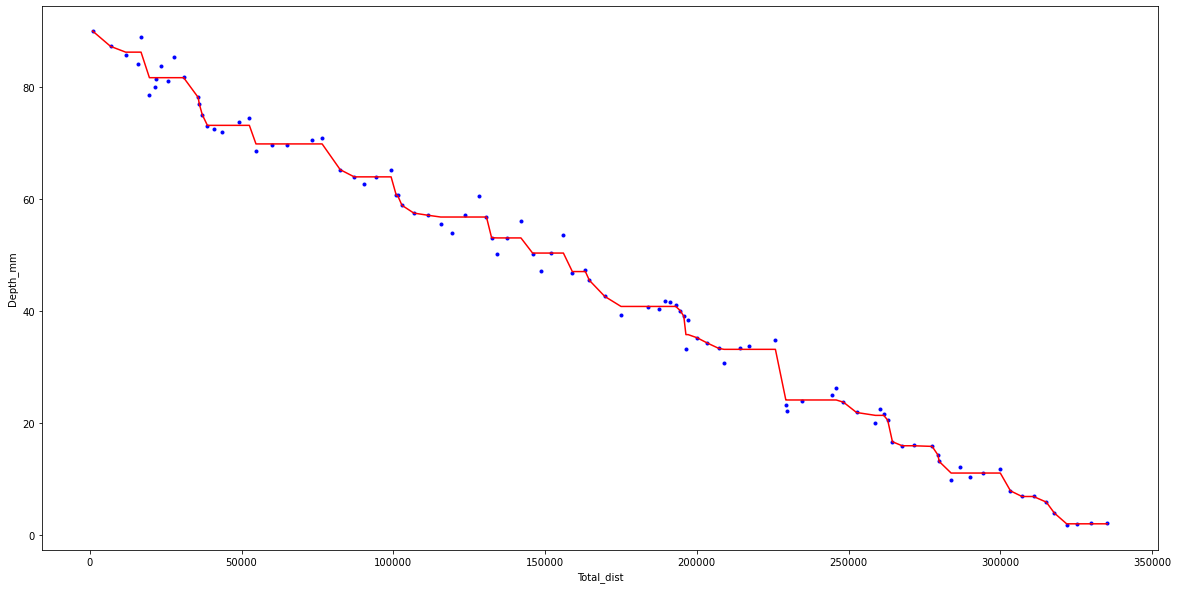

In [12]:
x = df.Total_dist
y = df.Depth_mm

plot_updated_depth(df.Depth_mm_corrected)

# Задание №2 (текст). Подход к факторному анализу износа шин

Необходимо оценить, какие факторы наиболее сильно влияют на износ шин:
- определить методику моделирования - что будет целевой переменной, на основе каких данных будет проводиться feature engineering
- определить набор факторов износа шин исходя из доступных данных и возможностей дооборудования/доп. измерений
- определить модели, которые будут тестироваться
- определить подход к факторному анализу - оценке степени значимости факторов. Необходимо, чтобы оценки влияния факторов стремились к независимости друг от друга
- определить подход к оценке влияния факторов в руб

В Вашем распоряжении есть накопленные данные за достаточный период:
- Автоматизированная система диспетчеризации (АСД)
    - Данные телематики - координаты (широта, долгота, высота) самосвалов с интервалом 10 сек с указанием номера самосвала, водителя, скорости, загрузки кузова в т, расхода топлива, оборотов двигателя, давления в шинах
    - Данные о рельефе - на предприятии есть 3D модель карьера с указанием поверхностей дорог с детализацией 5 см
- Отчет об измерениях глубины протектора: измерения глубины каждые 2 недели 
- Отчет о перестановках шин: дата время установки/снятия шины, машина откуда снята/установлена шина, позиция шины (колесная формула 2х4)

Текущие гипотезы по группам влияющих факторов:
- Рельеф
    - продольный, поперечный уклон дороги
    - шероховатость/качество дорожного покрытия - ямы, кочки и пр.
    - кол-во, радиус/крутизна виражей
- Скорость движения
- Загрузка кузова
- Место установки шины

**Задача**: напишите ответы на вопросы ниже

*Вопрос 1*: напишите примерную формулу расчета целевой переменной и укажите ее единицы измерения. Почему выбрали именно ее?

*Вопрос 2*: предложите перечень из 10-ти факторов, которые будут использованы для обучения модели, укажите к какой группе (см. выше) относится фактор, на основании каких данных (см. выше) эти факторы будут посчитаны

*Вопрос 3:* перечислите не менее 3-х классов моделей/подходов, которые могут быть использованы для моделирования? Какой подход предпочтительный и почему?  

*Вопрос 4*: какую метрику будете использовать для оценки точности модели? Почему именно ее?

*Вопрос 5*: какой метод будете использовать для оценки влияния каждого из факторов? В чем недостатки обычного feature importance?

*Вопрос 6* (\*): напишите (текстом) алгоритм расчета экономического эффекта от скоращения кол-ва требуемых шин за счет воздействия на один из факторов, напр., скорость

# Задание №3 (текст). Валидация модели

Представим, что предложенный Вами выше подход отлично сработал - Вы получили модель с MAPE 6%, $R^2$ 85%.
Вам даже удалось оценить плановый экономический эффект от воздействия на факторы износа шин - он составляет 30 млн руб/год
Коллеги из эксплуатации поверили в модель и сообщили о готовности по Вашим рекомендациям осуществлять:

1) корректировку состояния дорожного полотна - засыпают ямы и овраги, срезают кочки и холмы

2) своевременную подкачку и снижение давления - по Вашим оценкам это принесет 7 млн руб

Вы понимаете, что когда они проделают большую и сложную работу - от Вас попросят оценить, какой объем экономии принесла эта работа

**Задача**: предложите подход (текстом) к достоверному мониторингу снижения темпов износа шин по указанным 2-м направлениям. В карьере каждую 12-ч смену на работу (круглосуточно) выходят 40 самосвалов, совершают в месяц каждый по 9000 рейсов длиной по 3.5 км в среднем. У самосвалов нет постоянных маршрутов и зон работ - в течение месяца они равномерно ездят по всему карьеру


# Задание №4 (текст). Встраивание модели в прод

Отлично! Оцененный Вами эффект прошел экономичесую экспертизу, Вы и Ваши коллеги получили весомую премию (МИН(5% от эк. эффекта на рабочую группу;1.5 млн руб))
Принято решение разработать на основе модели приложение - рекомендательный сервис, какие дороги надо чинить в первую очередь, чтобы сэкономить на шинах

Для этого модель должна для каждого нового рейса выдавать индекс потерь на каждом участке дорог длиной 100 м (допустим, логика для этого уже реализована в наборе скриптов), записывать данные в БД и выдавать их по API другому микросервису + Вы планируете совершенствовать логику модели, непрерывно с ней эксперементируя и выкатывать новые версии

**Задача**: предложите подход, как эффективно организовать продуктивный процесс работы с моделью. В компании развернута Технологическая Платформа на базе Openshift, проблем с предоставлением ВМ также нет



# Задание №5 (код). Оптимизатор загрузки вагонов

Вы отлично проявили себя на проектах АО СГОК!

Теперь коллеги из ЖД логистики основной производственной площадки в Липецке просят Вашей помощи с автоматизацией и оптимизацией алгоритмов загрузки вагонов.

Одним из наиболее значимых по грузопотоку и выручке направлений является производство слябов. Слябы - это большие металлические слитки весом 3-60 тонн, которые отправляются клиентам в вагонах разной грузоподъемности и стоимости

Сейчас укладка планирование укладки слябов в вагоны производится вручную, что занимает длительные 2 ч в каждую смену + Вы проанализировали выборочно статистику и обнаружили потенциал применения для этой задачи алгоритмов численной оптимизации в 200 млн руб/год - игра стоит свеч!

**Задача**: напишлите код, который уложит слябы (табл. Units) в вагоны из перечня wagons_types *([(Грузоподъемность вагона типа 1 т/вагон, стоимость использования вагона 1 под перевозку, руб/вагон), (Грузоподъемность вагона типа 2 т/вагон, стоимость использования вагона 2 под перевозку, руб/вагон), ...])* с минимальной суммарной стоимостью

**Подсказка**: можете использовать любые библиотеки (ortools, mip, ...) / реализовать алгоритм смостоятельно (см. FFD и подобные). Если используете алгоритм приближенной оптимизации - укажите, почему

**Ограничение**: все слябы из units должны быть уложены в вагон, можно использовать только вагоны из перечня wagons_types, грузоподъемность вагона не должна превышаться

In [75]:
df_units = pd.read_excel('Units.xlsx')

In [76]:
wagons_types = [(75, 100000), (74, 90000), (73, 88000), (72, 87000), (69, 80000)]